In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
chart_studio.tools.set_credentials_file(username='samdeverett', api_key='bb3gUlCSDlQxHBX9Vm0r')

# Loading the Data

In [108]:
df = pd.read_csv('bms_exp2.csv')
print(df.shape)
df.head()

(6015, 10)


,id,consistency,difficulty,pain,smell,completeness,urgency,duration,occurred_at,fake_user_id
0,6162,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 19:10:00,480
1,6161,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 11:30:00,480
2,6131,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-03 14:05:00,480
3,6103,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 22:00:00,480
4,6102,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 14:00:00,480


# Exploring Data Analysis

How many users are there? How many BMs has each logged?

In [109]:
number = len(df['fake_user_id'].unique())
print(f'There are {number} users.')
df.groupby('fake_user_id').size().reset_index().rename(columns={0:'# BMs'}).sort_values('# BMs', ascending=False).head()

There are 98 users.


,fake_user_id,# BMs
65,1006,1000
66,1012,674
64,992,227
31,551,223
26,480,171


What percent of each values is null?

In [110]:
df.isnull().sum() / len(df) * 100

id               0.000000
consistency      1.213633
difficulty      49.609310
pain            70.656692
smell           66.932668
completeness    41.463009
urgency         55.627598
duration         0.000000
occurred_at      0.000000
fake_user_id     0.000000
dtype: float64

What percent of duration values are 0 (the default)?

In [111]:
len(df[df['duration'] == 0]) / len(df)

0.8513715710723192

Are the null values from a specific subset of users or well distributed among all them?

In [112]:
def get_user_null_values(df):
    user_null_values = {}
    for user_id in df['fake_user_id'].unique():
        user_df = df[df['fake_user_id'] == user_id]
        null_proportions = user_df.isnull().sum() / len(user_df)
        user_null_values[user_id] = null_proportions
    return user_null_values

In [113]:
def proportion_of_null_per_user(df, feature):
    null_proportions = {}
    user_null_values = get_user_null_values(df)
    for key in user_null_values:
        null_proportion = user_null_values[key][feature]
        null_proportions[key] = null_proportion
    return null_proportions

In [114]:
def plot_null_proportions_per_user(df, feature):
    dic = proportion_of_null_per_user(df, feature)
    ids = [str(i) for i in dic.keys()]
    proportions = list(dic.values())
    plt.figure(figsize=(20,10))
    plt.bar(ids, proportions)
    plt.xticks(rotation=90)
    plt.title(f'proportion of null {feature} values per user');

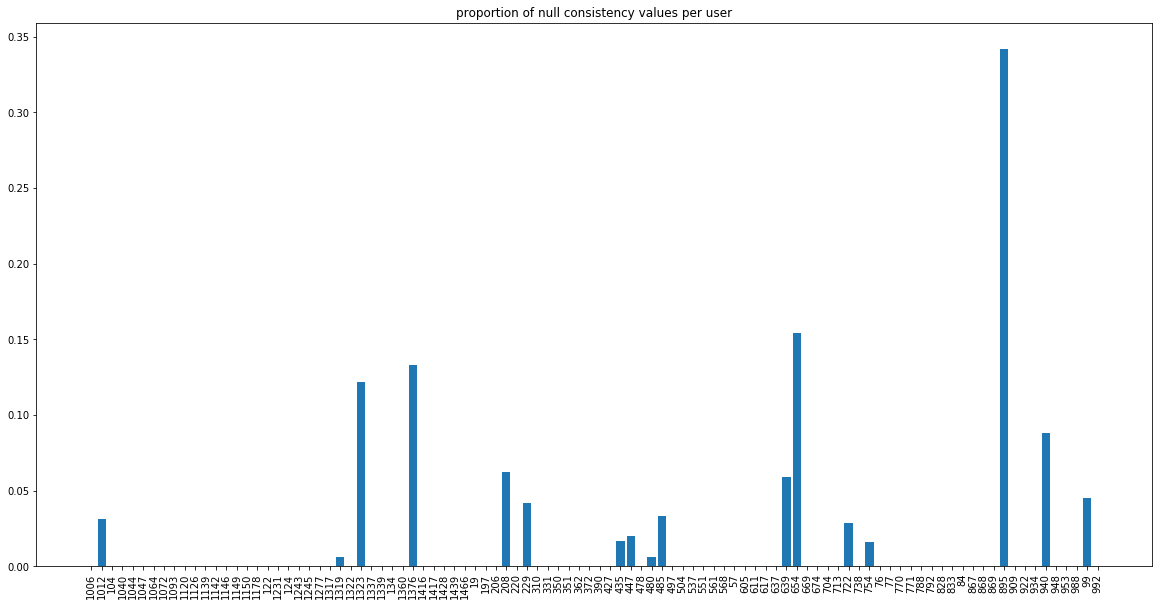

In [115]:
plot_null_proportions_per_user(df, 'consistency')

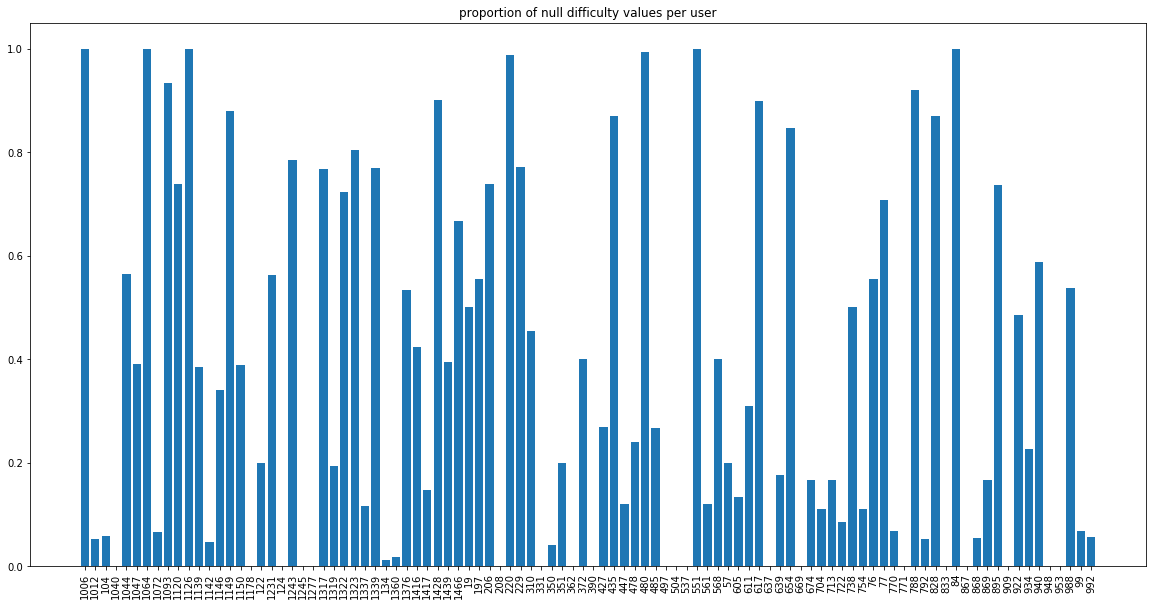

In [116]:
plot_null_proportions_per_user(df, 'difficulty')

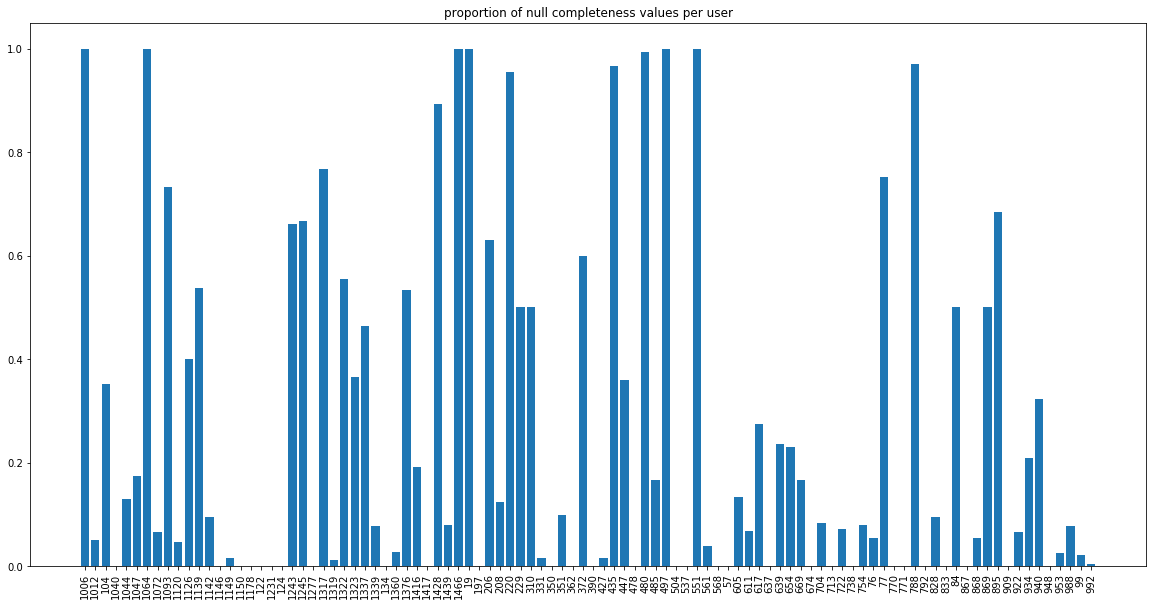

In [117]:
plot_null_proportions_per_user(df, 'completeness')

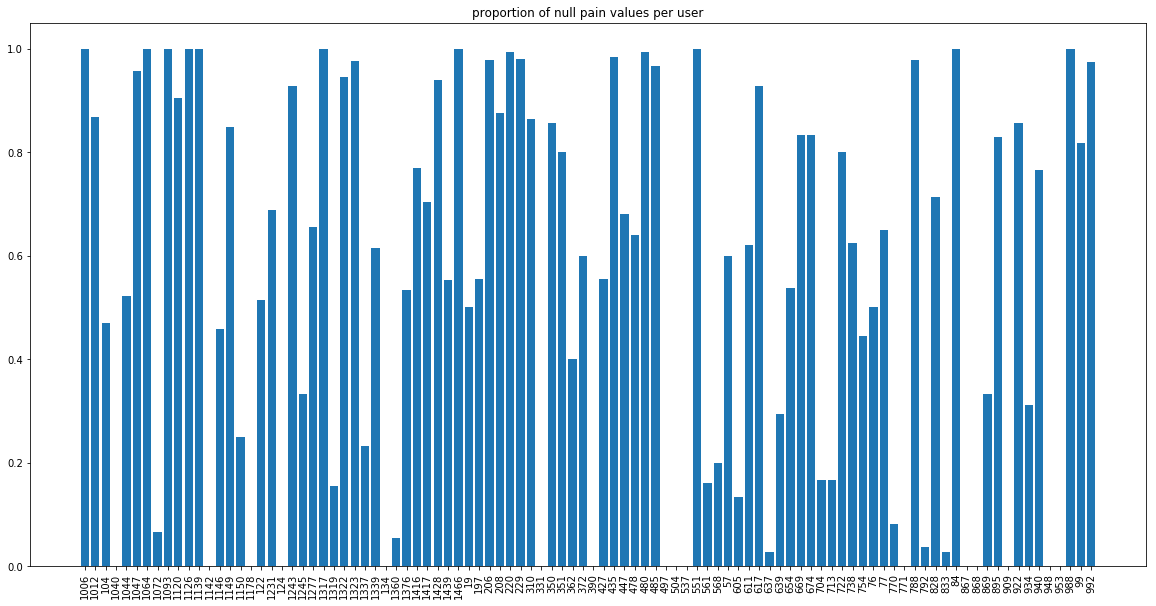

In [118]:
plot_null_proportions_per_user(df, 'pain')

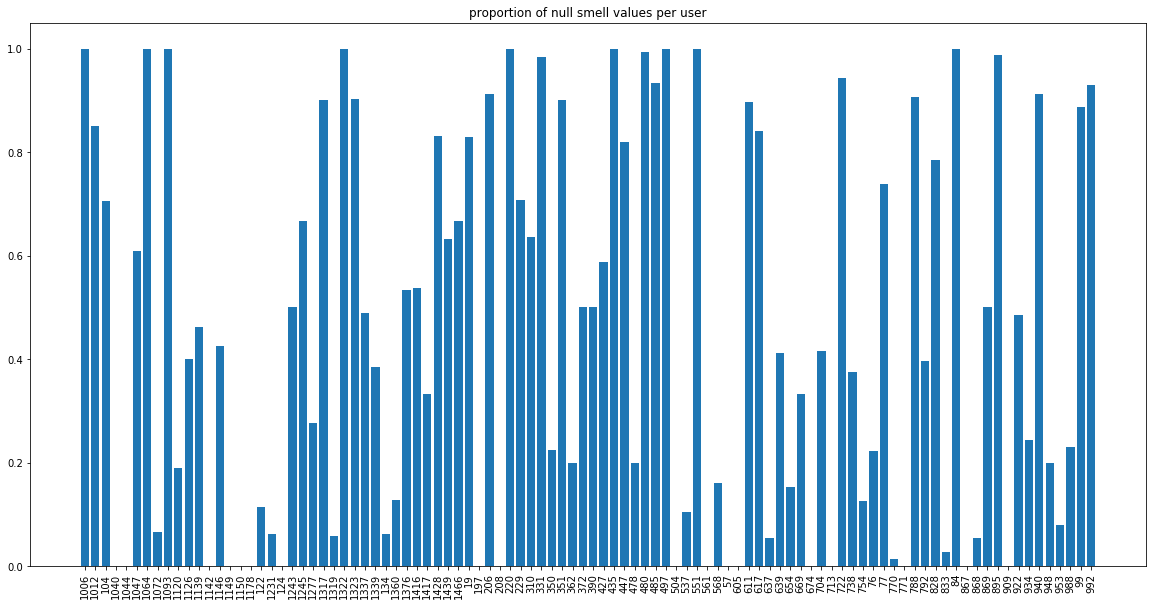

In [119]:
plot_null_proportions_per_user(df, 'smell')

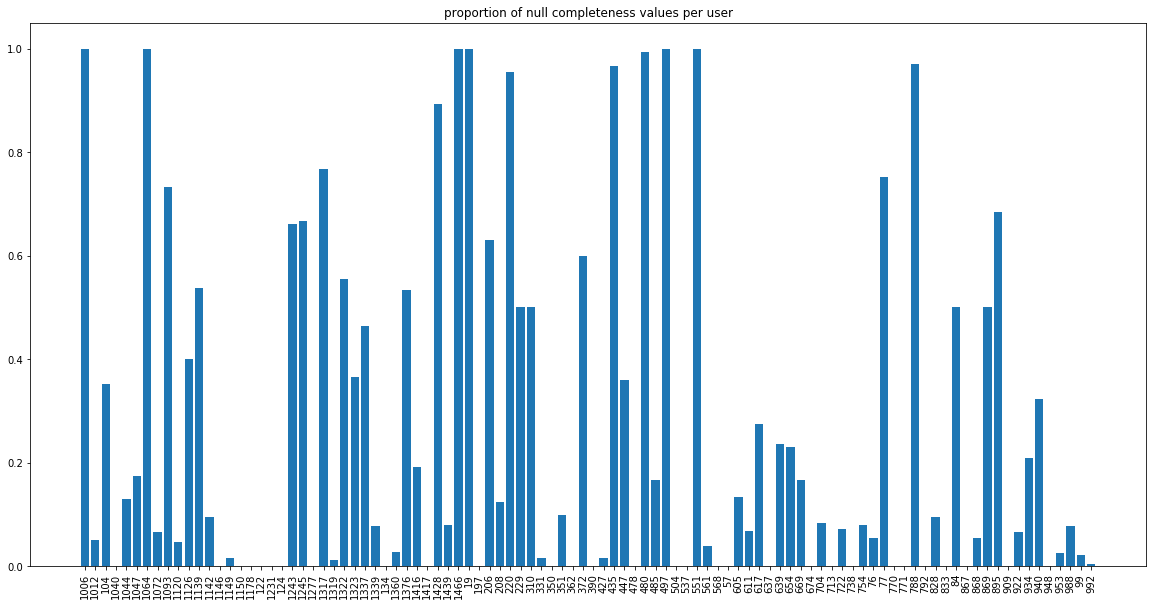

In [120]:
plot_null_proportions_per_user(df, 'completeness')

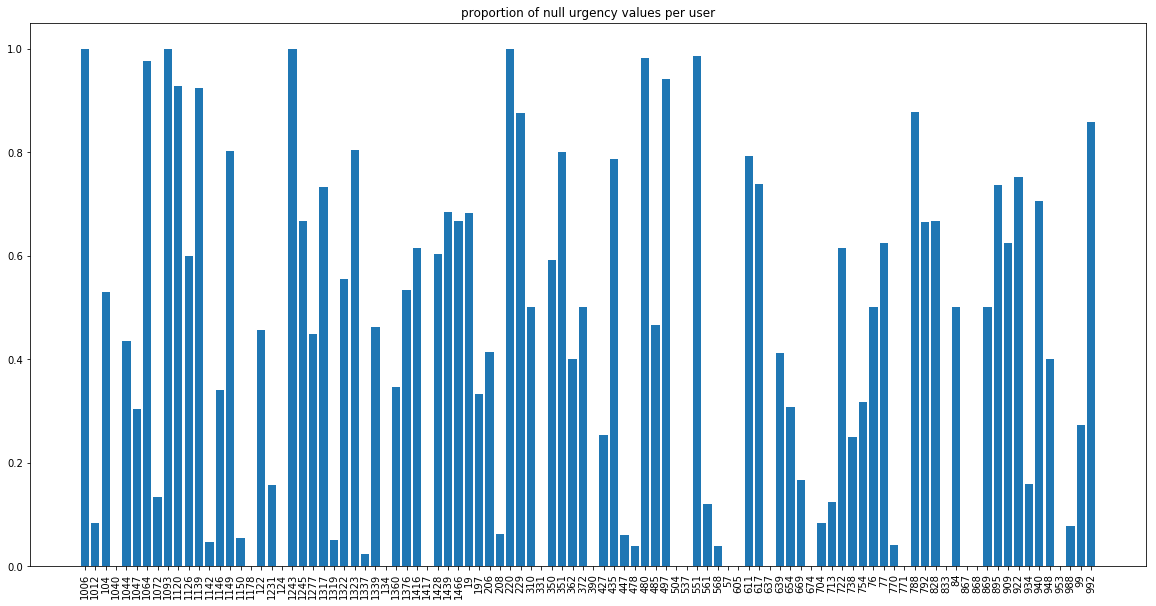

In [121]:
plot_null_proportions_per_user(df, 'urgency')

TAKEAWAY: null values for consistency come from a handful of users while null values for all other featuers seem to be spread across users.

# Clustering: Part I

Let's begin by clustering users based on their average conistency, difficulty, and completeness.

In this section, we will ignore null values. In other words, we will take the mean of these features for each user without imputing any values for their data points containing null values. 

Even with this methodology, it will be impossible to take the mean of a feature for a user who has never logged data for the feature. Thus, we must begin by dropping users who have either never logged consistency, difficulty, or completeness.

In [122]:
renames = {'consistency':'mean_consistency',
          'difficulty':'mean_difficulty',
          'completeness':'mean_completeness'}
df = df.groupby('fake_user_id').mean()[['consistency', 'difficulty', 'completeness']].rename(columns=renames)
df.dropna(inplace=True)
df.head()

,mean_consistency,mean_difficulty,mean_completeness
fake_user_id,,,
57,50.000000,12.500000,99.000000
76,48.333333,27.500000,80.882353
77,12.420382,15.543478,87.307692
99,53.214286,13.780488,57.093023
104,55.000000,27.500000,51.363636


Now that we have each user represented as a vector, we can begin clustering.

The first task is to find the optimal number of clusters. I will use the "elbow method" to do this. This method consists of running the clustering algorithm for a range of k values, where k is the number of clusters, calculating an error metric, like sum of squared error, for each, and then finding the value that maximizes the change in slope. For now, I will take the range of clusters to be 1 through 10.

In [123]:
def find_optimal_k(df):
    
    X = df
    scores = []
    possible_ks = range(1, 11)

    for k in possible_ks:
        kmeans = KMeans(n_clusters=k, random_state=42)   # set a random_state to be sure differences are due to k
        kmeans.fit(X)
        new_score = kmeans.inertia_   # inertia = SSE
        scores.append(new_score)
    
    plt.plot(possible_ks, scores)
    
    changes_in_score = np.diff(scores)
    optimal_k = possible_ks[np.argmin(changes_in_score) + 1]
    
    return optimal_k

The optimal number of clusters is 2.


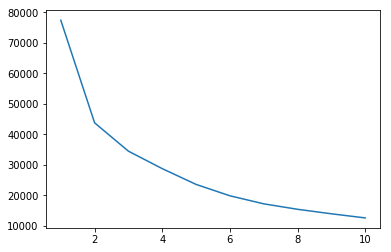

In [124]:
optimal_k = find_optimal_k(df)
print(f'The optimal number of clusters is {optimal_k}.')

We can corroborate this value by also using silhouette score as a goodness metric.

In [125]:
def find_optimal_k_using_silhouette(df):
    
    X = df
    silhouette_scores = []
    possible_ks = range(2, 11)

    for k in possible_ks:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        new_silhouette_score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(new_silhouette_score)
        
    plt.plot(possible_ks, silhouette_scores)
    
    return possible_ks[np.argmax(silhouette_scores)]

The optimal number of clusters using silhouette score is 2.


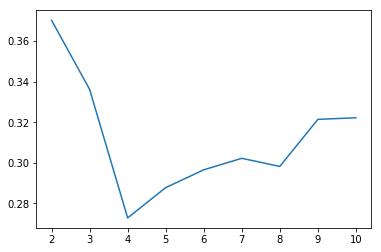

In [126]:
optimal_k_silhouette = find_optimal_k_using_silhouette(df)
print(f'The optimal number of clusters using silhouette score is {optimal_k_silhouette}.')

Now let's generating a K-Means clustering using that optimal number of clusters.

In [127]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df);

In [128]:
centers_1 = kmeans.cluster_centers_
print(f'The cluster centers are {centers_1[0]} and {centers_1[1]}')

The cluster centers are [ 38.98510105  18.28194527  81.49729461] and [ 47.0024992   34.91614526  47.2227757 ]


In [129]:
df['cluster'] = kmeans.labels_
print(f"There are {df[df['cluster'] == 0].shape[0]} points in cluster 1.")
print(f"There are {df[df['cluster'] == 1].shape[0]} points in cluster 2.")

There are 40 points in cluster 1.
There are 50 points in cluster 2.


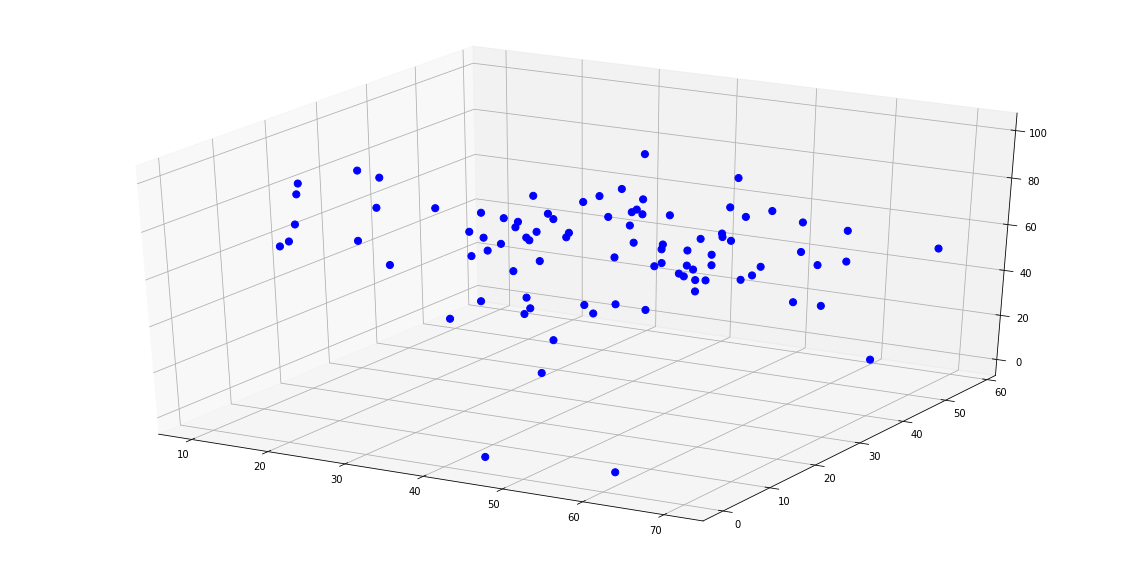

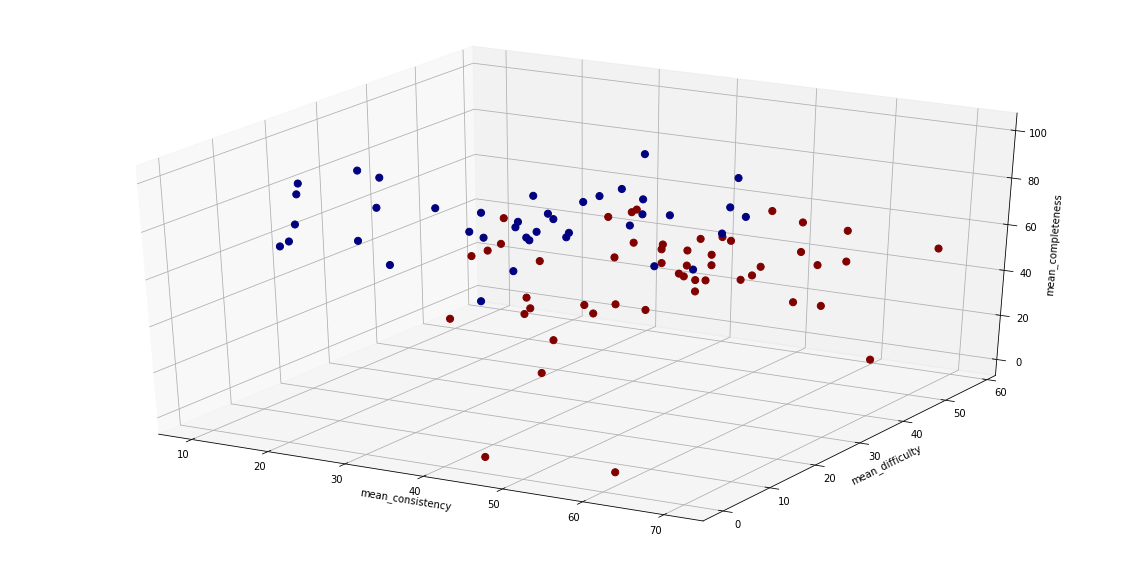

In [130]:
xs = df['mean_consistency']
ys = df['mean_difficulty']
zs = df['mean_completeness']

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, s=50, c='b', alpha=1)

fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(xs, ys, zs, s=50, c=df['cluster'], cmap='jet', alpha=1)
ax2.set_xlabel('mean_consistency')
ax2.set_ylabel('mean_difficulty')
ax2.set_zlabel('mean_completeness');

In [131]:
fig = px.scatter_3d(df, x='mean_consistency', y='mean_difficulty', z='mean_completeness', color='cluster')
fig.show()

# Data Pre-Processing

I want to be able to cluster based on consistency, difficulty, and completeness. I can't use the original data because of the proportion of null values. So, instead, for all users with null values in these features, I will impute data based on the values of the features that are not null. For example, if a user has the consistency data [40, 45, NaN, 55, 60], their consistency data will become [40, 45, 50, 55, 60].

In [132]:
# Retract the original data
df = pd.read_csv('bms_exp2.csv')
df.head()

,id,consistency,difficulty,pain,smell,completeness,urgency,duration,occurred_at,fake_user_id
0,6162,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 19:10:00,480
1,6161,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 11:30:00,480
2,6131,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-03 14:05:00,480
3,6103,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 22:00:00,480
4,6102,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 14:00:00,480


The first step is determining which users have null values for each of these features.

In [133]:
# From above
def get_user_null_values(df):
    user_null_values = {}
    for user_id in df['fake_user_id'].unique():
        user_df = df[df['fake_user_id'] == user_id]
        null_proportions = user_df.isnull().sum() / len(user_df)
        user_null_values[user_id] = null_proportions
    return user_null_values

In [134]:
# From above
def proportion_of_null_per_user(df, feature):
    null_proportions = {}
    user_null_values = get_user_null_values(df)
    for key in user_null_values:
        null_proportion = user_null_values[key][feature]
        null_proportions[key] = null_proportion
    return null_proportions

In [135]:
def get_users_with_nulls(df, feature):
    return [k for (k, v) in proportion_of_null_per_user(df, feature).items() if (v > 0)]

In [136]:
get_users_with_nulls(df, 'completeness')

[480,
 1439,
 1006,
 704,
 828,
 754,
 940,
 497,
 1142,
 1319,
 895,
 1149,
 229,
 124,
 1323,
 76,
 1360,
 654,
 1339,
 427,
 1044,
 551,
 351,
 485,
 1317,
 1139,
 922,
 77,
 331,
 605,
 1322,
 1245,
 1120,
 788,
 447,
 611,
 617,
 953,
 220,
 1093,
 988,
 310,
 669,
 992,
 1376,
 1012,
 1243,
 1466,
 1126,
 722,
 934,
 868,
 1337,
 99,
 639,
 104,
 561,
 1047,
 208,
 19,
 1064,
 1428,
 435,
 1416,
 869,
 206,
 372,
 84,
 1072]

Now we can impute values for each user with null values based on their non-null values.

In [137]:
def impute(df, feature):
    users_with_nulls = get_users_with_nulls(df, feature)
    for user in users_with_nulls:
        # Find the mean value of the user's non-null data points in that feature
        feature_avg_value = df[(df['fake_user_id'] == user) & ~(df[feature].isnull())].median()[feature]
        # Fill null data points of that feature with the value
        df.loc[(df['fake_user_id'] == user) & (df[feature].isnull()), feature] = feature_avg_value
    return df

In [138]:
df = impute(df, 'completeness')
get_users_with_nulls(df, 'completeness')

[1006, 497, 551, 1466, 19, 1064]

Why are there still users with null values?

In [139]:
{(k, v) for (k, v) in proportion_of_null_per_user(df, 'completeness').items() if k in get_users_with_nulls(df, 'completeness')}

{(19, 1.0), (497, 1.0), (551, 1.0), (1006, 1.0), (1064, 1.0), (1466, 1.0)}

These users have ALL values for this feature. In order to not weaken the strength of our clustering, we will not impute values for these users (say from the population average); instead, we will drop them. 

In [140]:
ids_to_drop = get_users_with_nulls(df, 'completeness')
df = df[~df['fake_user_id'].isin(ids_to_drop)]

We must now complete this procedure for the other features.

In [141]:
df = impute(df, 'consistency')
ids_to_drop = get_users_with_nulls(df, 'consistency')
df = df[~df['fake_user_id'].isin(ids_to_drop)]

In [142]:
df = impute(df, 'difficulty')
ids_to_drop = get_users_with_nulls(df, 'difficulty')
df = df[~df['fake_user_id'].isin(ids_to_drop)]

We have completed pre-processing our data to account for null values.

In [143]:
df.isnull().sum() / len(df) * 100

id               0.000000
consistency      0.000000
difficulty       0.000000
pain            62.995128
smell           57.996187
completeness     0.000000
urgency         43.677187
duration         0.000000
occurred_at      0.000000
fake_user_id     0.000000
dtype: float64

# Clustering: Part II

Let's now see if there's a difference in the clustering after having imputed null values.

In [144]:
renames = {'consistency':'mean_consistency',
          'difficulty':'mean_difficulty',
          'completeness':'mean_completeness'}
df = df.groupby('fake_user_id').mean()[['consistency', 'difficulty', 'completeness']].rename(columns=renames)
df.head()

,mean_consistency,mean_difficulty,mean_completeness
fake_user_id,,,
57,50.000000,13.000000,99.000000
76,48.333333,27.500000,81.388889
77,12.420382,11.624204,93.089172
99,53.295455,13.522727,57.159091
104,55.000000,26.470588,59.705882


The optimal number of clusters is 2.


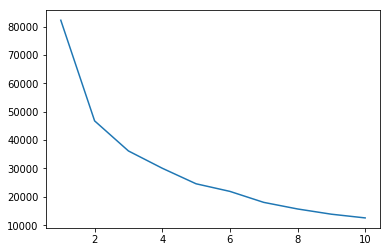

In [145]:
optimal_k = find_optimal_k(df)
print(f'The optimal number of clusters is {optimal_k}.')

The optimal number of clusters using silhouette score is 2.


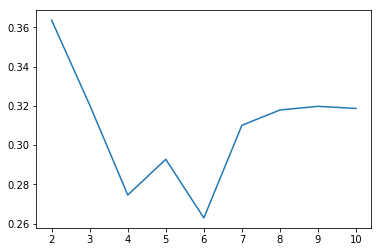

In [146]:
optimal_k_silhouette = find_optimal_k_using_silhouette(df)
print(f'The optimal number of clusters using silhouette score is {optimal_k_silhouette}.')

In [147]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df);

In [148]:
centers_2 = kmeans.cluster_centers_
print(f'The cluster centers are {centers_2[0]} and {centers_2[1]}')

The cluster centers are [ 47.12618902  32.55240584  61.66486753] and [ 39.59207564  19.37559967  31.2322633 ]


In [149]:
df['cluster'] = kmeans.labels_
print(f"There are {df[df['cluster'] == 0].shape[0]} points in cluster 1.")
print(f"There are {df[df['cluster'] == 1].shape[0]} points in cluster 2.")

There are 25 points in cluster 1.
There are 13 points in cluster 2.


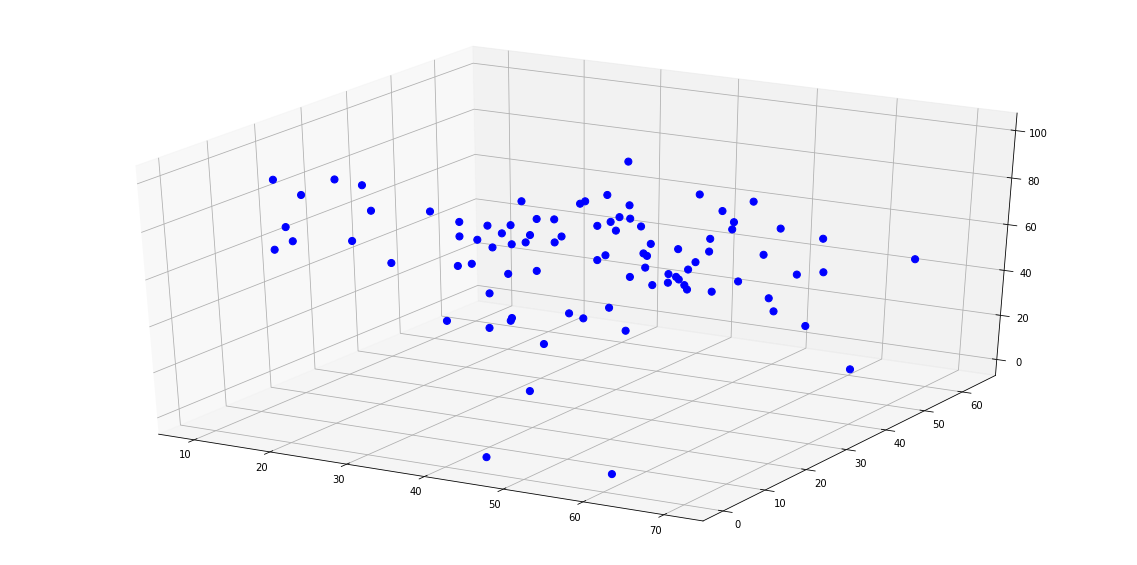

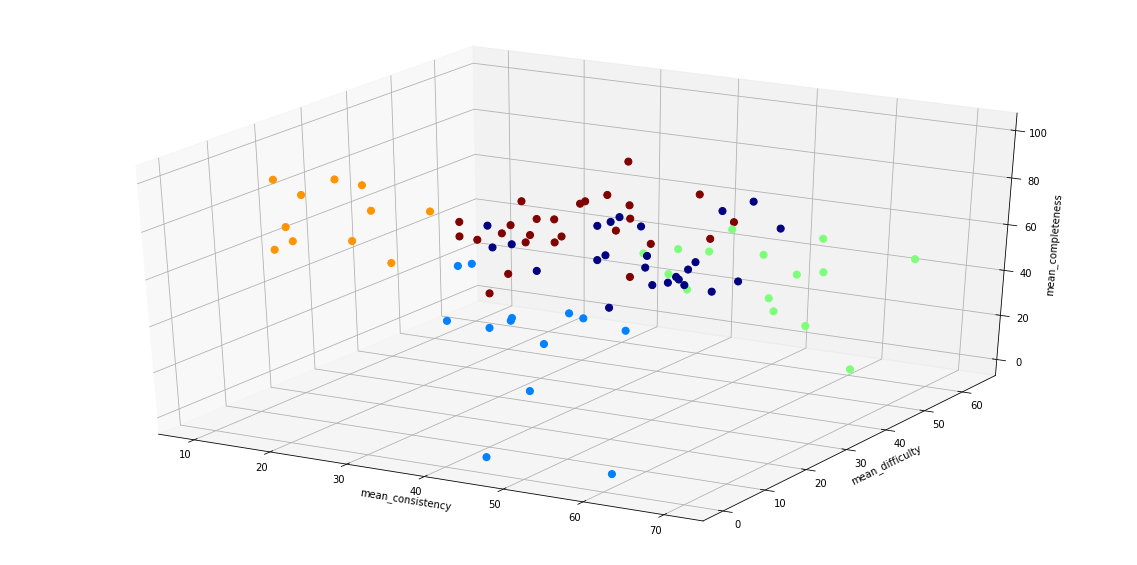

In [150]:
xs = df['mean_consistency']
ys = df['mean_difficulty']
zs = df['mean_completeness']

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, s=50, c='b', alpha=1)

fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(xs, ys, zs, s=50, c=df['cluster'], cmap='jet', alpha=1)
ax2.set_xlabel('mean_consistency')
ax2.set_ylabel('mean_difficulty')
ax2.set_zlabel('mean_completeness');

In [151]:
fig = px.scatter_3d(df, x='mean_consistency', y='mean_difficulty', z='mean_completeness', color='cluster')
fig.show()

# How Similar Are The Clusterings?

In [152]:
print(f'The centers in the first clustering are: {centers_1}.\n')
print(f'The centers in the second clustering are: {centers_2}.')

The centers in the first clustering are: [[ 38.98510105  18.28194527  81.49729461]
 [ 47.0024992   34.91614526  47.2227757 ]].

The centers in the second clustering are: [[ 47.12618902  32.55240584  61.66486753]
 [ 39.59207564  19.37559967  31.2322633 ]
 [ 53.16921888  50.50030911  41.25544806]
 [ 19.99375404  11.50382909  81.20847656]
 [ 46.21967626  18.36083834  83.68105443]].


They are nearly identical.
NOTE: This is likely because in the first clustering, null values were "under-the-hood" imputed as the means, while in the second they were computed as the medians. (Imputed null values by averages in the second clustering would have resulted in the exact same clustering as the first).

TAKEAWAY: The benefit of imputing null values does not seem worth its price.

# Is K-Means Even a Good Technique to be Using?

In [153]:
kmeans = KMeans(n_clusters=5, random_state=42)
X = df
kmeans.fit(X)
silhouette_score = silhouette_score(X, kmeans.labels_)
print(f'The silhouette score of these clusterings is around {silhouette_score}.')
if silhouette_score < 0.5:
    print('This value is a little low to proclaim good clustering...')
else:
    print('This suggests our clustering quality is strong.')

The silhouette score of these clusterings is around 0.2960344189899405.
This value is a little low to proclaim good clustering...


Furthermore, K-Means assumes that the data are spherical and the clusters are evenly sized. This is not necessary the case for IBS patients.

# Next Steps

1) Experiment with other user features. Aside from mean consistency, difficulty, and completeness, what factors may indicate/differentiate IBS patients?

(split up features into things like: % over/under threshold (50)

add symptoms
    - text stuff (ex: abdominal)
    - how many times they logged a symptom as a ratio of how long they've been using the app
    - aggregate by symptom name to see what percent of users logged a symptom
        - use top ones as features for clustering

write small story about each cluster - who's in them?
    - do they align with subdiagnoses of IBS?
    - if you cluster with k=5 and user vectors of size 3, can easily tell which clusters of patients have which tendencies (i.e. high difficulty)

2) Experiment with other clustering methods (e.g. hierarchical).